In [13]:
!nvidia-smi

Wed Oct 11 06:14:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os

In [16]:
!ls drive/MyDrive/garbage_classification_enhanced

battery     brown-glass  clothes      metal  plastic  trash
biological  cardboard	 green-glass  paper  shoes    white-glass


In [19]:
path = "drive/MyDrive/garbage_classification_enhanced/"

In [20]:
os.listdir(path)

['cardboard',
 'green-glass',
 'clothes',
 'brown-glass',
 'trash',
 'battery',
 'white-glass',
 'metal',
 'paper',
 'biological',
 'plastic',
 'shoes']

**Creating a Dataframe**

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [22]:
data = pd.DataFrame()
for category in os.listdir(path):
    temp = pd.DataFrame()
    temp['path'] = np.nan
    temp['target'] = category
    i = 0
    for photo in os.listdir(path + category):
        temp.loc[i, 'path'] = path + category + "/" + photo
        temp.loc[i, 'filename'] = category + "/" + photo
        temp.loc[i, 'target'] = category
        i += 1
    data = pd.concat([data, temp], ignore_index=True)
    del temp

In [23]:
data

,path,target,filename
0,drive/MyDrive/garbage_classification_enhanced/...,cardboard,cardboard/cardboard35.jpg
1,drive/MyDrive/garbage_classification_enhanced/...,cardboard,cardboard/cardboard618.jpg
2,drive/MyDrive/garbage_classification_enhanced/...,cardboard,cardboard/cardboard504.jpg
3,drive/MyDrive/garbage_classification_enhanced/...,cardboard,cardboard/cardboard609.jpg
4,drive/MyDrive/garbage_classification_enhanced/...,cardboard,cardboard/cardboard875.jpg
...,...,...,...
8434,drive/MyDrive/garbage_classification_enhanced/...,shoes,shoes/shoes1790.jpg
8435,drive/MyDrive/garbage_classification_enhanced/...,shoes,shoes/shoes338.jpg
8436,drive/MyDrive/garbage_classification_enhanced/...,shoes,shoes/shoes1586.jpg
8437,drive/MyDrive/garbage_classification_enhanced/...,shoes,shoes/shoes923.jpg


Displaying a random image

drive/MyDrive/garbage_classification_enhanced/paper/paper64.jpg


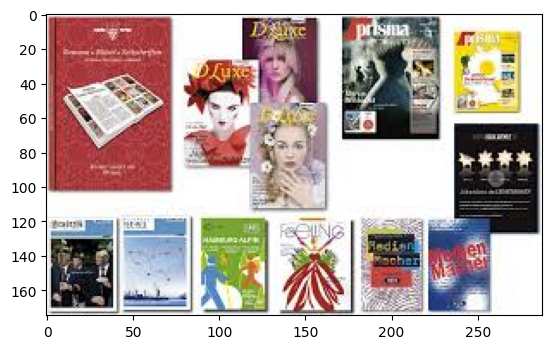

drive/MyDrive/garbage_classification_enhanced/trash/trash10.jpg


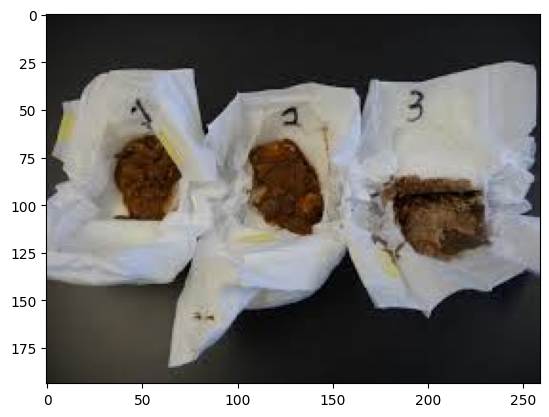

drive/MyDrive/garbage_classification_enhanced/cardboard/cardboard662.jpg


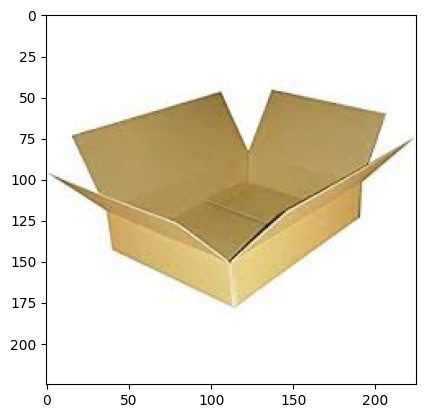

drive/MyDrive/garbage_classification_enhanced/white-glass/white-glass529.jpg


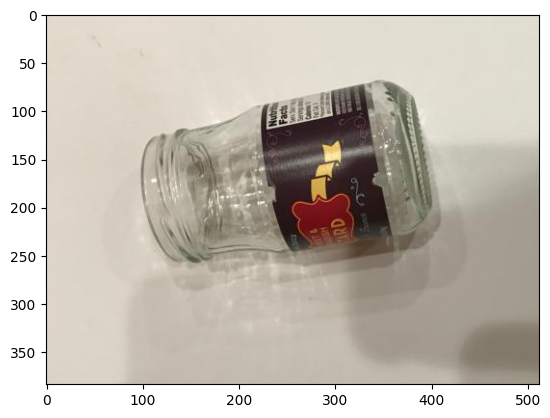

drive/MyDrive/garbage_classification_enhanced/cardboard/cardboard58.jpg


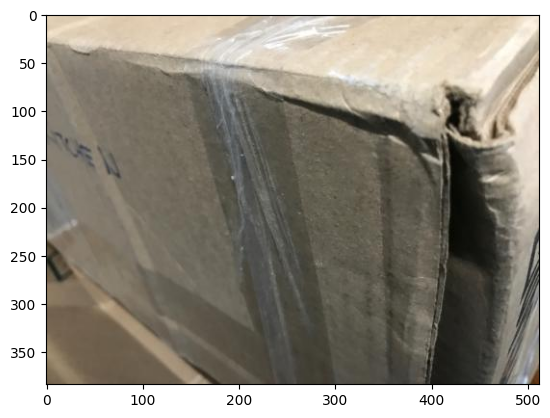

drive/MyDrive/garbage_classification_enhanced/green-glass/green-glass479.jpg


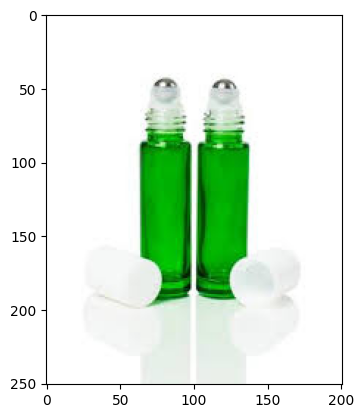

drive/MyDrive/garbage_classification_enhanced/biological/biological427.jpg


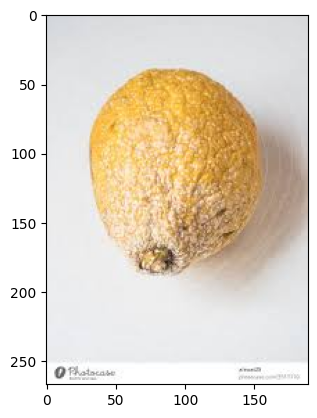

drive/MyDrive/garbage_classification_enhanced/brown-glass/brown-glass269.jpg


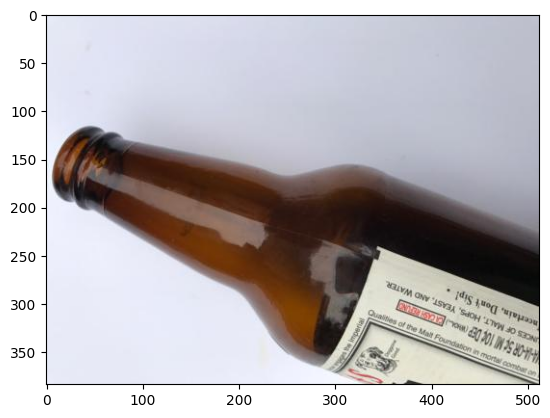

drive/MyDrive/garbage_classification_enhanced/brown-glass/brown-glass19.jpg


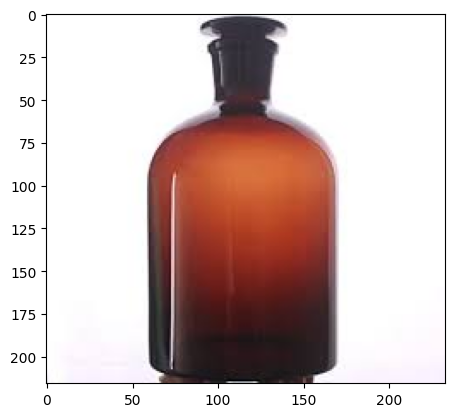

drive/MyDrive/garbage_classification_enhanced/cardboard/cardboard840.jpg


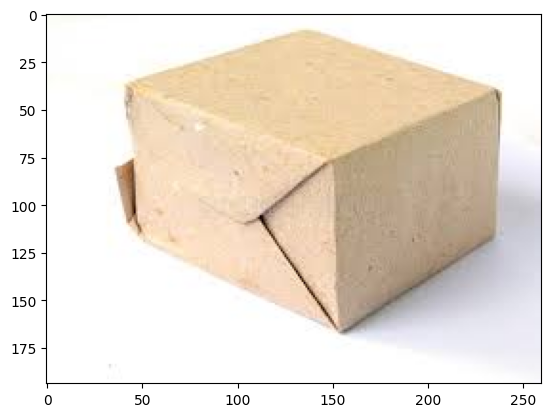

In [24]:
import random
import matplotlib.image as mpimg

for i in range (10):
    random_row = random.randint(0, len(data)-1)
    sample = data.iloc[random_row]
    image = mpimg.imread(sample['path'])
    plt.imshow(image)
    print(sample['path'])
    plt.show()

**Checking Counts for Items**

In [25]:
total_counts = 0

for category in os.listdir(path):
    count_class = 0
    for photo in os.listdir(path + category):
        count_class += 1
        total_counts += 1
    print(str(category) + " has " + str(count_class) + " photos")

cardboard has 720 photos
green-glass has 641 photos
clothes has 720 photos
brown-glass has 619 photos
trash has 720 photos
battery has 710 photos
white-glass has 749 photos
metal has 720 photos
paper has 720 photos
biological has 720 photos
plastic has 700 photos
shoes has 700 photos


**Pre-Processing Data**

Dataset has imbalanced data, need to sample down some from clothes and shoes class to make it balanced

In [26]:
from imblearn.under_sampling import RandomUnderSampler
data_dir = path

In [28]:
# List all image files in the subdirectories and assign labels
image_files = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.jpg'):
                image_files.append(os.path.join(class_dir, file_name))
                labels.append(class_name)

In [29]:
# Visualize the number of classes count
label_counts = pd.DataFrame(labels).value_counts()
label_counts

white-glass    749
biological     720
cardboard      720
clothes        720
metal          720
paper          720
trash          720
battery        710
plastic        700
shoes          700
green-glass    641
brown-glass    619
dtype: int64

In [30]:
# Storing number of classes
num_classes = len(label_counts)
num_classes

12

In [31]:
# Checking input image shape
image_files[0]

'drive/MyDrive/garbage_classification_enhanced/cardboard/cardboard35.jpg'

In [32]:
# Checking labels shape
labels = np.array(labels)
labels.shape

(8439,)

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# Apply undersampling to balance the classes
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(np.array(image_files).reshape(-1, 1), labels)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [35]:
# Flatten the resampled data
X_train = X_train.flatten()
X_test = X_test.flatten()

**Image Augmentation**

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:
# Set parameters for data augmentation (optional but recommended)
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [38]:
# Load and augment the training data
train_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_train, 'label': y_train}),
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),  # VGG16 input size
    batch_size=64,
    class_mode='categorical'
)

Found 5942 validated image filenames belonging to 12 classes.


In [39]:
# Load the test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_test, 'label': y_test}),
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 1486 validated image filenames belonging to 12 classes.


In [40]:
from sklearn.preprocessing import  LabelBinarizer

In [41]:
# Label binarizing
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['battery' 'biological' 'brown-glass' 'cardboard' 'clothes' 'green-glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white-glass']


In [42]:
# Splitting the training data set into training and validation data sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

**Model Training**

In [43]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [44]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


In [45]:
# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(12, activation='softmax')(x)  # 12 classes

In [46]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [47]:
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [48]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [49]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
93/93 [==============================] - 5252s 56s/step - loss: 1.4914 - accuracy: 0.5411 - val_loss: 1.0660 - val_accuracy: 0.6635
Epoch 2/10
93/93 [==============================] - 99s 1s/step - loss: 0.9238 - accuracy: 0.7174 - val_loss: 0.8350 - val_accuracy: 0.7301
Epoch 3/10
93/93 [==============================] - 101s 1s/step - loss: 0.7819 - accuracy: 0.7425 - val_loss: 0.7332 - val_accuracy: 0.7638
Epoch 4/10
93/93 [==============================] - 99s 1s/step - loss: 0.6932 - accuracy: 0.7789 - val_loss: 0.6801 - val_accuracy: 0.7705
Epoch 5/10
93/93 [==============================] - 106s 1s/step - loss: 0.6282 - accuracy: 0.7945 - val_loss: 0.6393 - val_accuracy: 0.7941
Epoch 6/10
93/93 [==============================] - 98s 1s/step - loss: 0.5874 - accuracy: 0.8092 - val_loss: 0.6357 - val_accuracy: 0.7934
Epoch 7/10
93/93 [==============================] - 103s 1s/step - loss: 0.5495 - accuracy: 0.8181 - val_loss: 0.6149 - val_accuracy: 0.8015
Epoch 8/10
93/

In [51]:
# Saving model
model.save("/content/drive/My Drive/ws.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


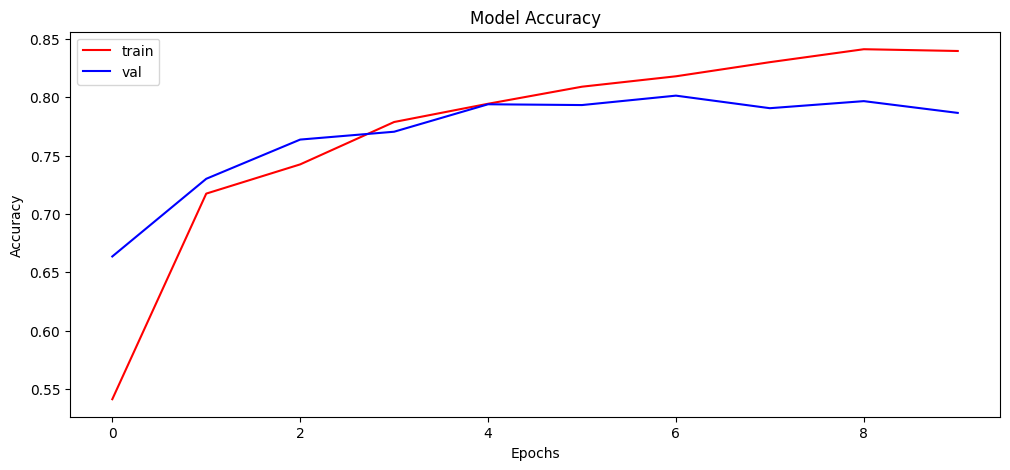

In [52]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

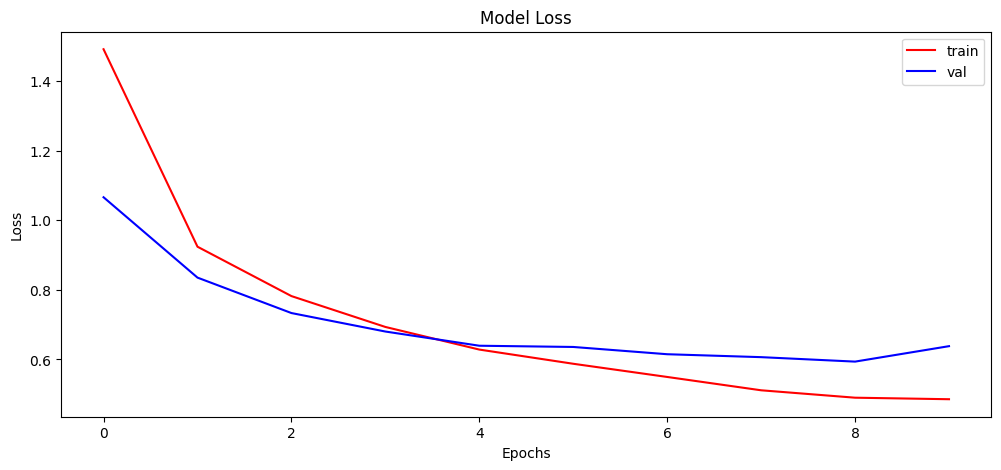

In [53]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [58]:
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model

In [59]:
model = load_model("/content/drive/My Drive/ws.h5")

In [60]:
# Prediction plot
def plot_prediction(img_path, prediction):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(prediction)
    plt.show()

In [63]:
# Calculating test accuracy
scores = model.evaluate(test_generator)
print(f"Test Accuracy: {scores[1]*100}")

24/24 [==============================] - 8s 310ms/step - loss: 0.6380 - accuracy: 0.7867
Test Accuracy: 78.66756319999695


In [64]:
# Storing predictions
y_pred = model.predict(test_generator)

24/24 [==============================] - 7s 303ms/step


In [70]:
y_pred

array([[8.35812767e-04, 3.63340747e-04, 2.01731369e-01, ...,
        7.93089032e-01, 2.21760838e-05, 1.36063644e-03],
       [1.45960797e-03, 1.09745351e-05, 2.71385312e-02, ...,
        5.60464412e-02, 1.55309863e-05, 1.81407601e-01],
       [1.43198995e-04, 8.05593911e-04, 7.61085033e-01, ...,
        1.35098724e-02, 1.14132534e-03, 4.31368686e-02],
       ...,
       [5.92775352e-04, 2.97081715e-04, 6.62900720e-06, ...,
        1.79450661e-02, 5.02414346e-01, 3.41002684e-04],
       [6.47693514e-06, 2.24944202e-07, 3.34655829e-02, ...,
        3.19986407e-06, 4.00090130e-08, 1.21601835e-04],
       [1.21823899e-01, 2.30548234e-04, 3.64937596e-02, ...,
        1.89728744e-04, 4.90253791e-02, 1.77984104e-01]], dtype=float32)

In [72]:
classname = np.argmax(y_pred,axis=1)[0]
print(classname)

9


In [71]:
type(test_generator)

keras.src.preprocessing.image.DataFrameIterator

In [73]:
from keras.applications.vgg16 import preprocess_input

In [79]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [80]:
# Load the trained model
model = load_model("/content/drive/My Drive/ws.h5")

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
os.listdir(path)

['cardboard',
 'green-glass',
 'clothes',
 'brown-glass',
 'trash',
 'battery',
 'white-glass',
 'metal',
 'paper',
 'biological',
 'plastic',
 'shoes']

In [90]:
!ls drive/MyDrive/garbage_classification_enhanced/metal/metal639.jpg

drive/MyDrive/garbage_classification_enhanced/metal/metal639.jpg


In [91]:
# Load and preprocess the user-input image
image_path = path + "metal/metal639.jpg"
img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize the image

# Make predictions
predictions = model.predict(img)

# Get the class with the highest probability
predicted_class = np.argmax(predictions)

1/1 [==============================] - 1s 893ms/step


In [94]:
class_names = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [95]:
predicted_class_name = class_names[predicted_class]

In [96]:
predicted_class_name

'metal'